In [1]:
%pylab inline
figsize(18, 9)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from imp import reload
from itertools import islice
import json
import webdataset as wds
import scipy.ndimage as ndi
import torchmore
import torch
from ocropus import slog
from ocropus import ocroseg
from ocropus.ocroseg import Segmenter
assert torch.cuda.is_available()

# Getting Started

- download models with `./run download`
- download training data with `./run download_uw3`
- install virtualenv with `./run venv`
- start up Jupyter with `./run lab`
- open this notebook and run it

In [3]:
!test -f gsub-tess-test.tar || wget -O gsub-tess-test.tar http://storage.googleapis.com/ocropus4-test/gsub-tess-test.tar
!tar tvf gsub-tess-test.tar | head

-rwxr-xr-x bigdata/bigdata 21746 2021-08-19 12:42 Volume_0935/Image_0028.hocr
-rwxr-xr-x bigdata/bigdata 400950 2021-08-19 12:42 Volume_0935/Image_0028.JPEG
-rwxr-xr-x bigdata/bigdata 468883 2021-08-19 12:42 Volume_0523/Image_0136.JPEG
-rwxr-xr-x bigdata/bigdata  98363 2021-08-19 12:42 Volume_0523/Image_0136.hocr
-rwxr-xr-x bigdata/bigdata 415787 2021-08-19 12:42 Volume_0934/Image_0037.JPEG
-rwxr-xr-x bigdata/bigdata  39017 2021-08-19 12:42 Volume_0934/Image_0037.hocr
-rwxr-xr-x bigdata/bigdata 159218 2021-08-19 12:42 Volume_0160/Image_0144.JPEG
-rwxr-xr-x bigdata/bigdata   7159 2021-08-19 12:42 Volume_0160/Image_0144.hocr
-rwxr-xr-x bigdata/bigdata 375738 2021-08-19 12:42 Volume_0425/Image_0253.JPEG
-rwxr-xr-x bigdata/bigdata  29108 2021-08-19 12:42 Volume_0425/Image_0253.hocr
tar: write error


In [4]:
!test -f gsub-wseg-test.tar || wget -O gsub-wseg-test.tar http://storage.googleapis.com/ocropus4-test/gsub-wseg-test.tar
!tar tvf gsub-wseg-test.tar | head

-rwxr-xr-x bigdata/bigdata 1067 2021-08-19 12:41 Volume_0133/Image_0055@-45,1734.seg.png
-rwxr-xr-x bigdata/bigdata 16047 2021-08-19 12:41 Volume_0133/Image_0055@-45,1734.png
-rwxr-xr-x bigdata/bigdata 21557 2021-08-19 12:41 Volume_0482/Image_0103@482,-180.png
-rwxr-xr-x bigdata/bigdata   683 2021-08-19 12:41 Volume_0482/Image_0103@482,-180.seg.png
-rwxr-xr-x bigdata/bigdata 61530 2021-08-19 12:41 Volume_0138/Image_0148@559,1538.png
-rwxr-xr-x bigdata/bigdata  2236 2021-08-19 12:41 Volume_0138/Image_0148@559,1538.seg.png
-rwxr-xr-x bigdata/bigdata 79123 2021-08-19 12:41 Volume_0178/Image_0080@-98,665.png
-rwxr-xr-x bigdata/bigdata  4012 2021-08-19 12:41 Volume_0178/Image_0080@-98,665.seg.png
-rwxr-xr-x bigdata/bigdata 94984 2021-08-19 12:41 Volume_0948/Image_0104@-98,908.png
-rwxr-xr-x bigdata/bigdata  2939 2021-08-19 12:41 Volume_0948/Image_0104@-98,908.seg.png
tar: write error


In [5]:
!test -f gsub-words-test.tar || wget -O gsub-words-test.tar http://storage.googleapis.com/ocropus4-test/gsub-words-test.tar
!tar tvf gsub-words-test.tar | head

-rwxr-xr-x bigdata/bigdata  20 2021-08-19 12:41 Volume_0935/Image_0028@0.bbox.json
-rwxr-xr-x bigdata/bigdata 5748 2021-08-19 12:41 Volume_0935/Image_0028@0.png
-rwxr-xr-x bigdata/bigdata    2 2021-08-19 12:41 Volume_0935/Image_0028@0.txt
-rwxr-xr-x bigdata/bigdata   20 2021-08-19 12:41 Volume_0935/Image_0028@1.bbox.json
-rwxr-xr-x bigdata/bigdata 9001 2021-08-19 12:41 Volume_0935/Image_0028@1.png
-rwxr-xr-x bigdata/bigdata    4 2021-08-19 12:41 Volume_0935/Image_0028@1.txt
-rwxr-xr-x bigdata/bigdata 7878 2021-08-19 12:41 Volume_0935/Image_0028@2.png
-rwxr-xr-x bigdata/bigdata    3 2021-08-19 12:41 Volume_0935/Image_0028@2.txt
-rwxr-xr-x bigdata/bigdata   20 2021-08-19 12:41 Volume_0935/Image_0028@2.bbox.json
-rwxr-xr-x bigdata/bigdata   20 2021-08-19 12:41 Volume_0935/Image_0028@3.bbox.json
tar: write error


In [23]:
!test -f ia1-000000.tar || wget -O ia1-000000.tar http://storage.googleapis.com/ocropus4-test/ia1-000000.tar

--2021-09-03 09:27:03--  http://storage.googleapis.com/ocropus4-test/ia1-000000.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.80, 142.250.217.112, 142.251.33.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1528852480 (1.4G) [application/octet-stream]
Saving to: ‘ia1-000000.tar’

ia1-000000.tar      100%[===================>]   1.42G  32.6MB/s    in 46s     

2021-09-03 09:27:50 (31.4 MB/s) - ‘ia1-000000.tar’ saved [1528852480/1528852480]



# Dataset Access

All data for OCRopus4 is stored as tar archives. We use the `webdataset` library for reading those tar files for training and recognition.

dict_keys(['__key__', '__url__', '__worker__', '__rank__', '__nodeinfo__', 'bbox.json', 'png', 'txt'])


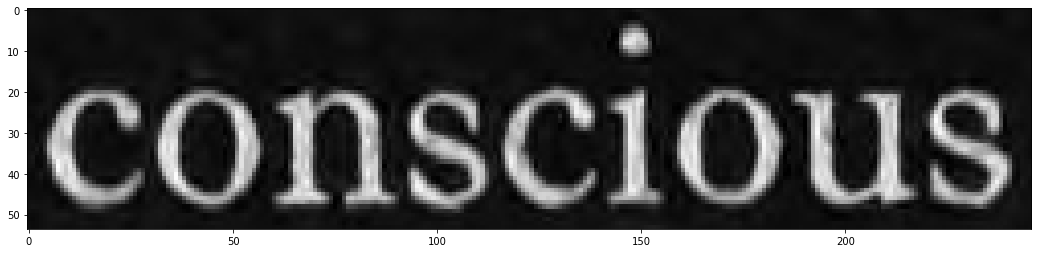

In [26]:
ds = wds.WebDataset("ia1-000000.tar").decode("l")
src = iter(ds)
sample = next(islice(src, 10, 9999))
print(sample.keys())
page = sample["png"]
imshow(page)

# Segmentation

OCRopus4 contains a number of segmenters for dividing up the page into different page elements. They all work in a similar way, but there are usually small differences in resolution and pre/post processing.

The most common segmenter is a word segmenter; it will divide up the page into individual words.

Word segmenters come in different varieties depending on the ground truth they are trained on.

- If word segmenters are trained on the raw input image with the final OCR bounding boxes for the body text, they will perform page frame removal, text/image segmentation, text/table segmentation, text/math segmentation, and word segmentation all in a single step.
- If word segmenters are trained after page cropping / boundary noise removal, they will perform all the above functions above except for page frame removal.
- If word segmenters are trained "masked", i.e., only on those image regions that contain target words, they will detect words anywhere on the page, including inside boundary noise, inside tables, and inside images.

Masked models are usually the most predictable and reliable, but they may require pre- and post-processing on noisy data.

In [7]:
!test -f wsegmodel.pth || wget -O wsegmodel.pth https://storage.googleapis.com/ocropus4-models/wsegmodel.pth

dict_keys(['__key__', '__url__', '__worker__', '__rank__', '__nodeinfo__', 'jpeg', 'hocr'])


cuda:0


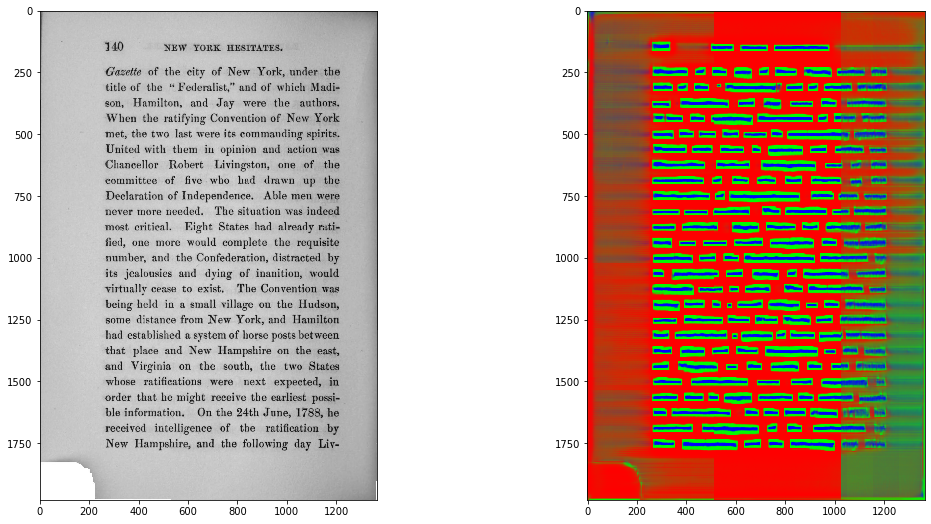

In [14]:
from ocropus import loading
from ocropus import nlbin
ds = wds.WebDataset("gsub-tess-test.tar").decode("l")
reload(ocroseg)
src = iter(islice(ds, 9, 10))
sample = next(src)
print(sample.keys())
page = sample["jpeg"]
# page = nlbin.nlbin(page.astype(float))
model = loading.load_only_model("wsegmodel.pth")
segmenter = Segmenter(model)
segmenter.segment(page)
figsize(18, 9)
subplot(121); imshow(page)
subplot(122); imshow(segmenter.probs[:,:,1:4])

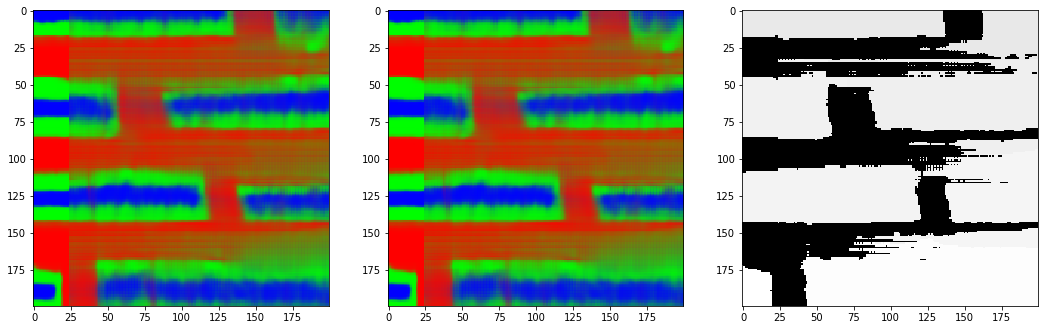

In [16]:
subplot(131); imshow(segmenter.probs[1000:1200, 1000:1200, 1:4], vmin=0, vmax=1)
subplot(132); imshow(segmenter.gprobs[1000:1200, 1000:1200, 1:4], vmin=0, vmax=1)
subplot(133); imshow(segmenter.segments[1000:1200, 1000:1200])

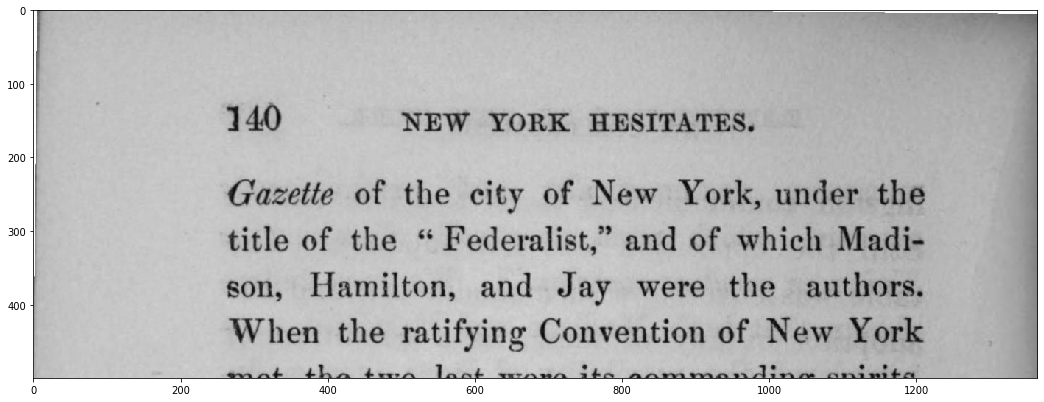

In [17]:
imshow(page[:500])

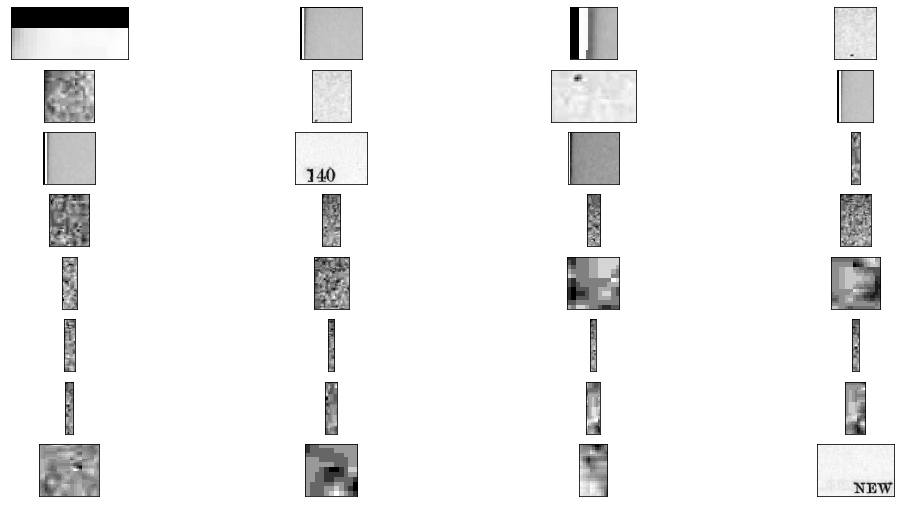

In [18]:
boxes = segmenter.segment(page)
words = ocroseg.extract_boxes(page, boxes)
for i, s in enumerate(words):
    if i>=32: break
    subplot(8, 4, i+1); xticks([]); yticks([])
    imshow(s)

We need to deactivate a model at the end of inference to unload it from the GPU.

In [19]:
segmenter.activate(False)

# Text Recognition

We start by loading a text recognition model. Apart from the network architecture itself, there are two important distinctions among models:

- word models are trained on individual words; they usually can't recognize spaces; line models are trained on entire lines
- normalized models perform a heuristic line image normalization before training; unnormalized models don't

Line models generally work reasonably well on words, but word models don't work well on entire text lines.

Which is best depends on a number of factors. Here we load a word model for normalized word images.

The recognition API is the same regardless of which model you load.

In [22]:
from ocropus import ocrorec
reload(ocrorec)
model = loading.load_only_model("wordmodel.pth")
rec = ocrorec.TextRec(model)

cuda:0


Here we use a simple API to recognize each word individually, without any additional batching.
The recognizer API just takes a word or line image and returns the corresponding UTF-8 string.
There are more APIs for getting more detailed information on recognition.

In [ ]:
for i, s in enumerate(words):
    if i>=40: break
    subplot(5, 8, i+1)
    imshow(s)
    xticks([]); yticks([])
    result = rec.recognize(s)
    title(result)

In [ ]:
rec.activate(False)

# Full Page Recognition Pipeline

The `ocrlib.pagerec.PageRecognizer` class encapsulates all the steps necessary for recognizing entire pages of text. This performs multiple recognition steps:

- word segmentation
- line segmentation (for grouping words into lines)
- block segmentation (for grouping lines into blocks)
- word recognition

In [ ]:
pr = PageRecognizer()
pr.load_config("./ocropus4.yaml")

In [ ]:
result = pr.recognize_page(page)
#json.dumps(result, indent=4)[:200]

In [ ]:
str(result["lines"][10])

In [ ]:
" ".join([w["output"] for w in result["lines"][10]["words"]])

In [ ]:
result["lines"][10]["box"]

In [ ]:
imshow(page[706:749, 233:1896])